<a href="https://colab.research.google.com/github/adib0073/AiTutorials/blob/main/TimeSeries/time_series_forecasting_w_arima_sarima.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <center>Time Series Forecasting w/ ARIMA</center>


#### Links + Resources

Throughout the notebook I implement and reword ideas from the following sources. Thank you to all for sharing!

[A Deep Dive on Arima Models](https://towardsdatascience.com/a-deep-dive-on-arima-models-8900c199ccf) - by Matt Sosna <-- MUST READ!

[Time Series For beginners with ARIMA](https://www.kaggle.com/freespirit08/time-series-for-beginners-with-arima/notebook) - by [@Arindam Chatterjee](https://www.kaggle.com/freespirit08)

[Arima Model for Time Series Forecasting](https://www.kaggle.com/prashant111/arima-model-for-time-series-forecasting#14.-SARIMA-model-in-python-) - by [@Prashant Banerjee](https://www.kaggle.com/prashant111)

[StatsModels ADF Documentation](https://www.statsmodels.org/stable/examples/notebooks/generated/stationarity_detrending_adf_kpss.html?highlight=augmented%20dickey%20fuller%20test)

[Removing Trends and Seasonality Article](https://machinelearningmastery.com/remove-trends-seasonality-difference-transform-python/) - by Jason Brownlee

[A Gentle Introduction to SARIMA](https://machinelearningmastery.com/sarima-for-time-series-forecasting-in-python/) - by Jason Brownlee

---

## <center>ARIMA</center>

The ARIMA model stands for "Auto-Regressive Integrated Moving Average" and can be broken down into AR, I, MA.

This section is [a-deep-dive-on-arima-models](https://towardsdatascience.com/a-deep-dive-on-arima-models-8900c199ccf) yet in my own words. Thanks to Matt Sosna for sharing this amazing article and for the images!

---

### <center>Autoregressive Component - AR(p)</center>

The autoregressive component of the ARIMA model is represented by AR(p), with the p parameter determining the number of lagged series that we use.

<p align="center">
  <img src="https://miro.medium.com/max/1400/1*8If_nqKxNbzd3JPZAXICVg.png" />
</p>

#### AR(0): White Noise

- If we set the p parameter as zero (AR(0)), with no autoregressive terms. This time series is just white noise.

- Each data point is sampled from a distribution with a mean of 0 and a variance of sigma-squared.

- This results in a sequence of random numbers that can't be predicted.

- This is really useful as it can serve as a null hypothesis, and protect our analyses from accepting false-positive patterns.

#### AR(1): Random Walks and Oscillations

- With the p parameter set to 1, we are taking into account the previous timestamp adjusted by a multiplier, and then adding white noise.

- If the multiplier is 0 then we get white noise, and if the multiplier is 1 we get a random walk.

- If the multiplier is between 0 < α₁ < 1, then the time series will exhibit mean reversion. This means that the values tend to hover around 0 and revert to the mean after regressing from it.

#### AR(p): Higher-order terms

- Increasing the p parameter even further is just means going further back and adding more timestamps adjusted by their own multipliers.

- We can go as far back as we want, but as we get further back it is more likely that we should use additional parameters such as the moving average (MA(q)).

---

### <center>Moving Average - MA(q)</center>

"This component is not a rolling average, but rather the lags in the white noise."

#### MA(q)

- MA(q) is the moving average model and q is the number of lagged forecasting error terms in the prediction.

- In an MA(1) model, our forecast is a constant term plus the previous white noise term times a multiplier, added with the current white noise term.

- This is just simple probability + statistics, as we are adjusting our forecast based on previous white noise terms.

## <center>ARMA and ARIMA Models</center>

ARMA and ARIMA architectures are just the AR (Autoregressive) and MA (Moving Average) components put together.

#### ARMA

The ARMA model is a constant plus the sum of AR lags and their multipliers, plus the sum of the MA lags and their multipliers plus white noise. This equation is the basis of all the models that come next and is a framework for many forecasting models across different domains.

#### ARIMA

<p align="center">
  <img src="https://miro.medium.com/max/1400/1*t2vQXShddn_RNJno_oSgIQ.png" />
</p>

- The ARIMA model is an ARMA model yet with a preprocessing step included in the model that we represent using I(d).

- I(d) is the difference order, which is the number of transformations needed to make the data stationary.

- So, an ARIMA model is simply an ARMA model on the differenced time series.

## <center>SARIMA, ARIMAX, SARIMAX Models</center>

The ARIMA model is great, but to include seasonality and exogenous variables in the model can be extremely powerful. Since the ARIMA model assumes that the time series is stationary, we need to use a different model.

#### SARIMA

<p align="center">
  <img src="https://miro.medium.com/max/1400/1*feNkO5nl2ET5EXZ2vG8mQg.png" />
</p>

- Enter SARIMA (Seasonal ARIMA). This model is very similar to the ARIMA model, except that there is an additional set of autoregressive and moving average components.

- These additional lags are offset by the frequency of seasonality (ex. 12 - monthly, 24 - hourly).

- SARIMA models allow for differencing data by seasonal frequency, yet also by non-seasonal differencing.

- Knowing which parameters are best can be made easier through automatic parameter search frameworks such as `pmdarima`

#### ARIMAX and SARIMAX

<p align="center">
  <img src="https://miro.medium.com/max/1400/1*wdyr2r-FSIncbHXQTbpZaQ.png" />
</p>

- The final version of the ARMA model is the ARIMAX and SARIMAX models.

- These models take into account exogenous variables, or in other words, use external data in our forecast.

- Some real-world examples of exogenous variables include gold price, oil price, outdoor temperature, exchange rate.

- It is interesting to think that all exogenous factors are still technically indirectly modeled in the historical model forecast. That being said, if we include external data, we will respond much quicker to that than if we rely on the influence of lagging terms.


In [1]:
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams

import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.stattools import adfuller
!pip install pmdarima --quiet
import pmdarima as pm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 10.0 MB/s eta 0:00:00


## <center>Loading Data</center>

For this notebook, I am going to use the [Air Passengers Dataset](https://www.kaggle.com/rakannimer/air-passengers). This dataset contains the number of air travel passengers from the start of 1949 to the end of 1960.

This dataset has a positive trend and a monthly seasonality.

As soon as the dataset is read, the index is set to the date. This is standard practice when working with time-series data in Pandas, and makes it easy to implement ARIMA, SARIMA, and SARIMAX later in the notebook.

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/AileenNielsen/TimeSeriesAnalysisWithPython/master/data/AirPassengers.csv")

#string to date format
df['Month'] = pd.to_datetime(df['Month'],infer_datetime_format=True)
df = df.set_index(['Month'])
df.head(5)

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


## <center>Components of Time-Series Data</center>

<B>Trend</B>
- The general direction of the data over time. For example, if we are looking at the height of a newborn baby, their height will follow an upward trend into their youth. On the other hand, someone on a successful weight loss program will see their weight follow a downward trend over time.

<B>Seasonality + Cycles</B>
- Any seasonal or repeating patterns with a fixed frequency. Could be hourly, monthly, daily, annually, etc. One example of this is that Winter Jacket sales increase in the winter months and decrease in the summer months. Another example of this could be the balance of your bank account. In the 10 days at the start of every month, your balance follows a downward trend as you pay monthly rent, utilities, and other bill payments.

<B>Irregularities + Noise</B>
- Any large spikes or troughs in the data. One example of this could be your heart rate when you run the 400-meter dash. When you start the race your heart rate is similar to what it has been throughout the day, but during the race, it spikes to a much higher level for a small period of time before returning to a normal level.

---
In the visualization of the airline passenger's data, we can look for these components. At first glance, there looks to be a positive trend and some sort of seasonality or cyclicity in the dataset. There does not appear to be any major irregularities or noise in the data.

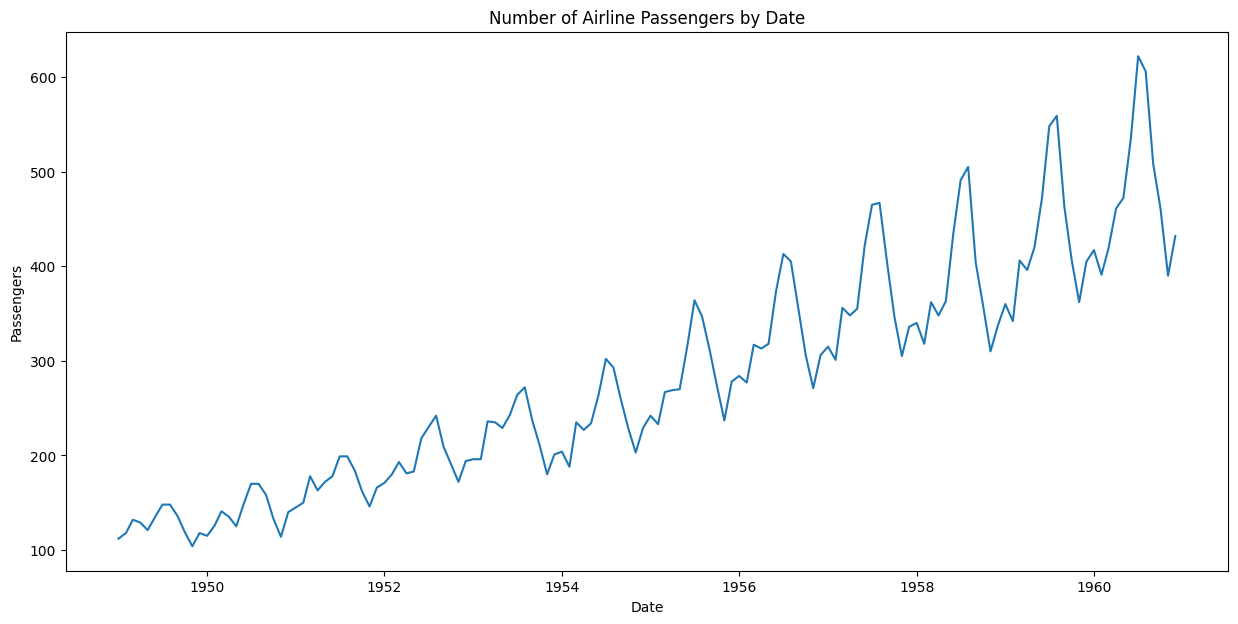

In [3]:
plt.figure(figsize=(15,7))
plt.title("Number of Airline Passengers by Date")
plt.xlabel('Date')
plt.ylabel('Passengers')
plt.plot(df)
plt.show()

## <center> Rolling Statistics

A rolling average is a great way to visualize how the dataset is trending. As the dataset provides counts by month, a window size of 12 will give us the annual rolling average.

We will also include the rolling standard deviation to see how much the data varies from the rolling average.

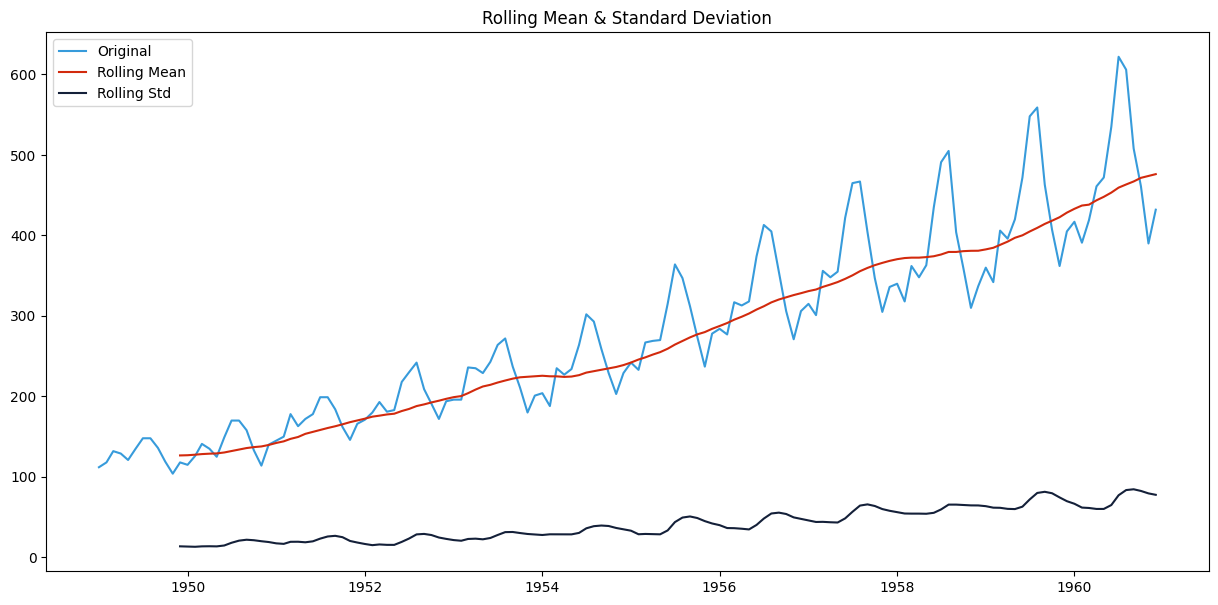

In [4]:
#Determine rolling statistics
df["rolling_avg"] = df["#Passengers"].rolling(window=12).mean() #window size 12 denotes 12 months, giving rolling mean at yearly level
df["rolling_std"] = df["#Passengers"].rolling(window=12).std()

#Plot rolling statistics
plt.figure(figsize=(15,7))
plt.plot(df["#Passengers"], color='#379BDB', label='Original')
plt.plot(df["rolling_avg"], color='#D22A0D', label='Rolling Mean')
plt.plot(df["rolling_std"], color='#142039', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

## <center>Augmented Dickey–Fuller Test</center>

The Augmented Dickey-Fuller Test is used to determine if time-series data is stationary or not. Similar to a t-test, we set a significance level before the test and make conclusions on the hypothesis based on the resulting p-value.

<B>Null Hypothesis:</B> The data is not stationary.

<B>Alternative Hypothesis:</B> The data is stationary.

For the data to be stationary (ie. reject the null hypothesis), the ADF test should have:

- p-value <= significance level (0.01, 0.05, 0.10, etc.)

If the p-value is greater than the significance level then we can say that it is likely that the data is not stationary.

We can see in the ADF test below that the p-value is 0.991880, meaning that it is very likely that the data is not stationary.

In [5]:
#Augmented Dickey–Fuller test:
print('Results of Dickey Fuller Test:')
dftest = adfuller(df['#Passengers'], autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value

print(dfoutput)

Results of Dickey Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


## <center>ARIMA Model Selection w/ Auto-ARIMA</center>

Although our data is almost certainly not stationary (p-value = 0.991), let's see how well a standard ARIMA model performs on the time series

Using the auto_arima function from the `pmdarima` package, we can perform a parameter search for the optimal values of the model.


IMPORTANT NOTE:
- When we print out the model summary after training, the header will be SARIMAX regardless of what model parameters we use. If we set the seasonality to FALSE or the m parameter to 1 then we have a standard ARIMA model. This will be what we train first. See this Stack Overflow question for more information --> [auto_arima(... , seasonal=False) but got SARIMAX?](https://stackoverflow.com/questions/69528507/auto-arima-seasonal-false-but-got-sarimax)

In [6]:
#Standard ARIMA Model
ARIMA_model = pm.auto_arima(df['#Passengers'],
                      start_p=1,
                      start_q=1,
                      test='adf', # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1, # frequency of series (if m==1, seasonal is set to FALSE automatically)
                      d=None,# let model determine 'd'
                      seasonal=False, # No Seasonality for standard ARIMA
                      trace=False, #logs
                      error_action='warn', #shows errors ('ignore' silences these)
                      suppress_warnings=True,
                      stepwise=True)
print(ARIMA_model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  144
Model:               SARIMAX(2, 0, 1)   Log Likelihood                -699.125
Date:                Sat, 26 Aug 2023   AIC                           1408.249
Time:                        13:42:02   BIC                           1423.098
Sample:                    01-01-1949   HQIC                          1414.283
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     19.6007     12.051      1.627      0.104      -4.018      43.219
ar.L1          0.4990      0.131      3.822      0.000       0.243       0.755
ar.L2          0.4314      0.124      3.466      0.0

## <center>Model Diagnostics</center>

Four plots result from the plot_diagnostics function. The Standardized residual, Histogram plus KDE estimate, Normal q-q, and a correlogram.

We can interpret the model as a good fit based on the following conditions.

Standardized residual
- There are no obvious patterns in the residuals, with values having a mean of zero and having a uniform variance.

Histogram plus KDE estimate
- The KDE curve should be very similar to the normal distribution (labeled as N(0,1) in the plot)

Normal Q-Q
- Most of the data points should lie on the straight line

Correlogram (ACF plot)
- 95% of correlations for lag greater than zero should not be significant. The grey area is the confidence band, and if values fall outside of this then they are statistically significant. In our case, there are a few values outside of this area, and therefore we may need to add more predictors to make the model more accurate

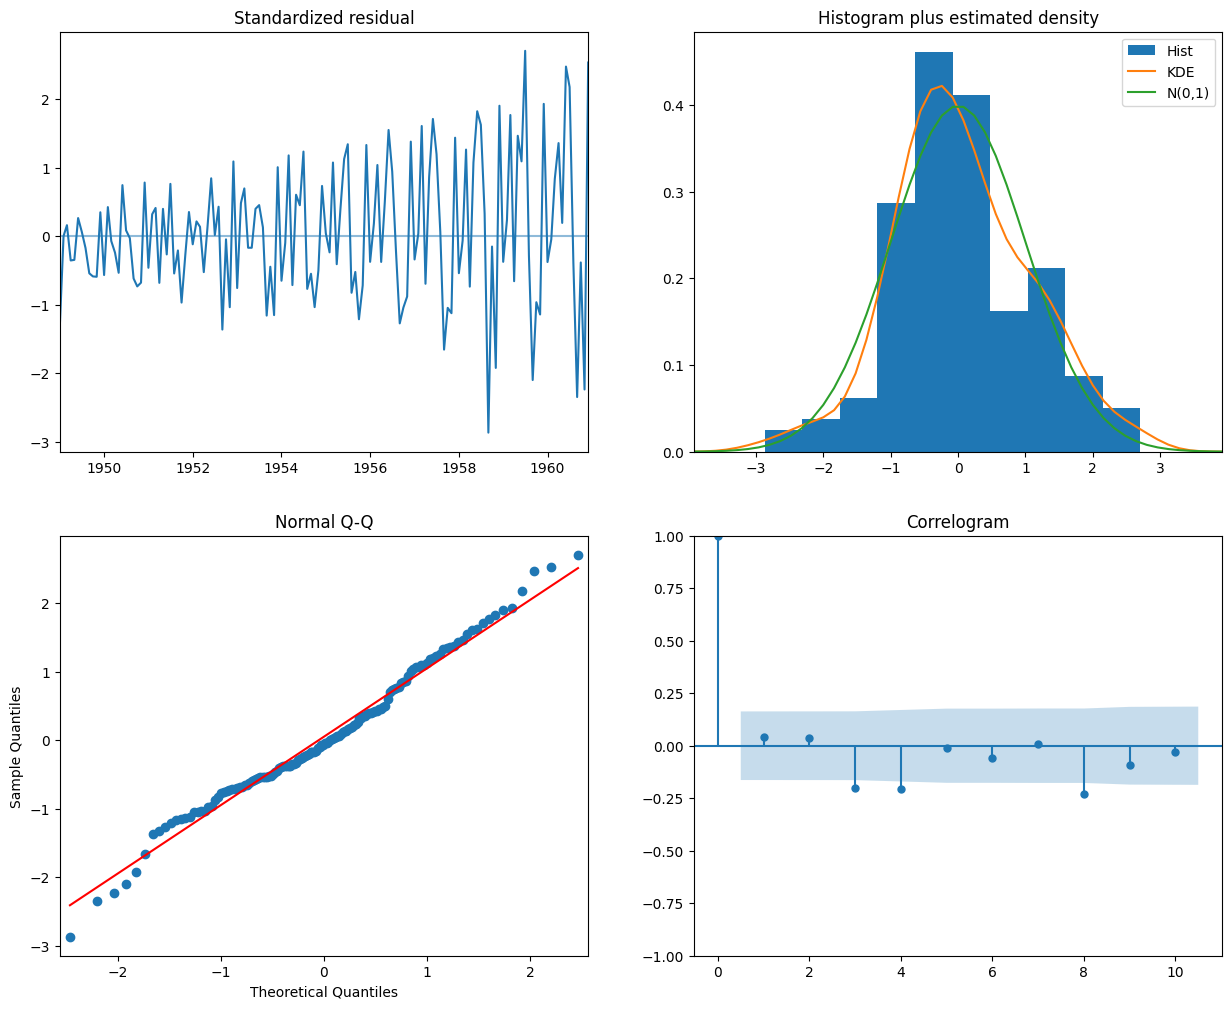

In [7]:
ARIMA_model.plot_diagnostics(figsize=(15,12))
plt.show()

We can then use the model to forecast airline passenger counts over the next 24 months.

As we can see from the plot below, this doesn't seem to be a very accurate forecast. Maybe we need to change the model structure so that it takes into account seasonality?

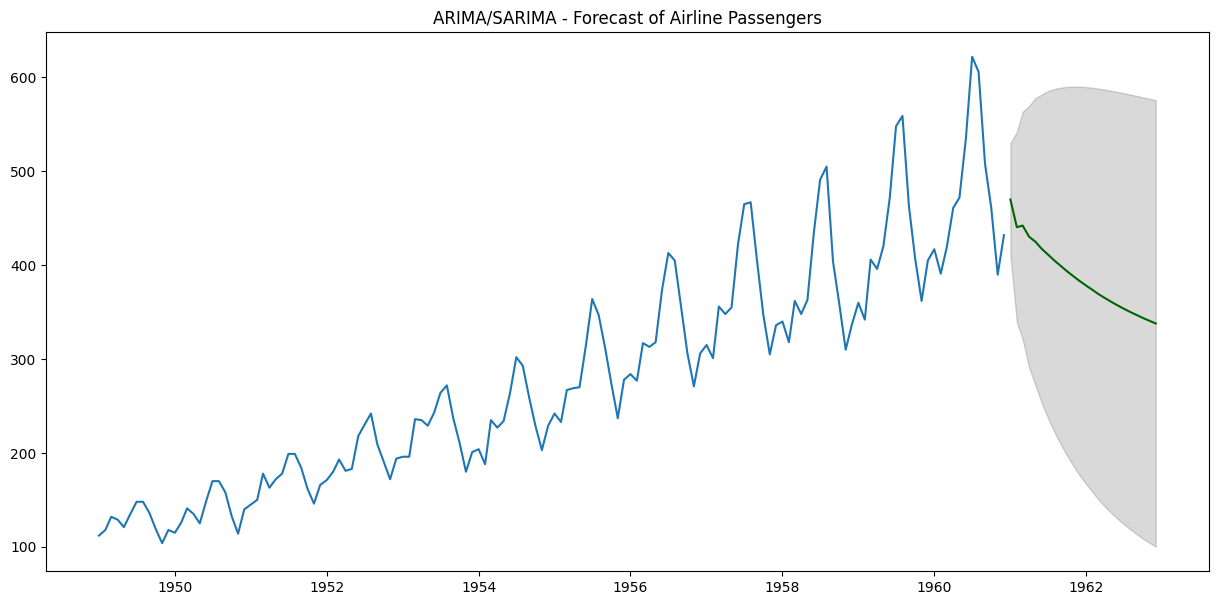

In [8]:
def forecast(ARIMA_model, periods=24):
    # Forecast
    n_periods = periods
    fitted, confint = ARIMA_model.predict(n_periods=n_periods, return_conf_int=True)
    index_of_fc = pd.date_range(df.index[-1] + pd.DateOffset(months=1), periods = n_periods, freq='MS')

    # make series for plotting purpose
    fitted_series = pd.Series(fitted, index=index_of_fc)
    lower_series = pd.Series(confint[:, 0], index=index_of_fc)
    upper_series = pd.Series(confint[:, 1], index=index_of_fc)

    # Plot
    plt.figure(figsize=(15,7))
    plt.plot(df["#Passengers"], color='#1f76b4')
    plt.plot(fitted_series, color='darkgreen')
    plt.fill_between(lower_series.index,
                    lower_series,
                    upper_series,
                    color='k', alpha=.15)

    plt.title("ARIMA/SARIMA - Forecast of Airline Passengers")
    plt.show()

forecast(ARIMA_model)

## <center>SARIMA Model Selection</center>

Now let's try the same strategy as we did above, except let's use a SARIMA model so that we can account for seasonality.

In [9]:
# Seasonal - fit stepwise auto-ARIMA
SARIMA_model = pm.auto_arima(df["#Passengers"], start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3,
                         m=12, #12 is the frequncy of the cycle
                         start_P=0,
                         seasonal=True, #set to seasonal
                         d=None,
                         D=1, #order of the seasonal differencing
                         trace=False,
                         error_action='ignore',
                         suppress_warnings=True,
                         stepwise=True)

Taking a look at the model diagnostics, we can see some significant differences when compared with the standard ARIMA model.

Standardized residual
- The Standardized residual is much more consistent across the graph, meaning that the data is closer to being stationary.

Histogram plus KDE estimate
- The KDE curve is similar to the normal distribution (not much changed here).

Normal Q-Q
- The data points are clustered much closer to the line than in the ARIMA diagnostic plot.

Correlogram (ACF plot)
- The grey area is the confidence band, and if values fall outside of this then they are statistically significant. We want all values inside this area. Adding the seasonality component did this! All the points now fall within the 95% confidence interval.

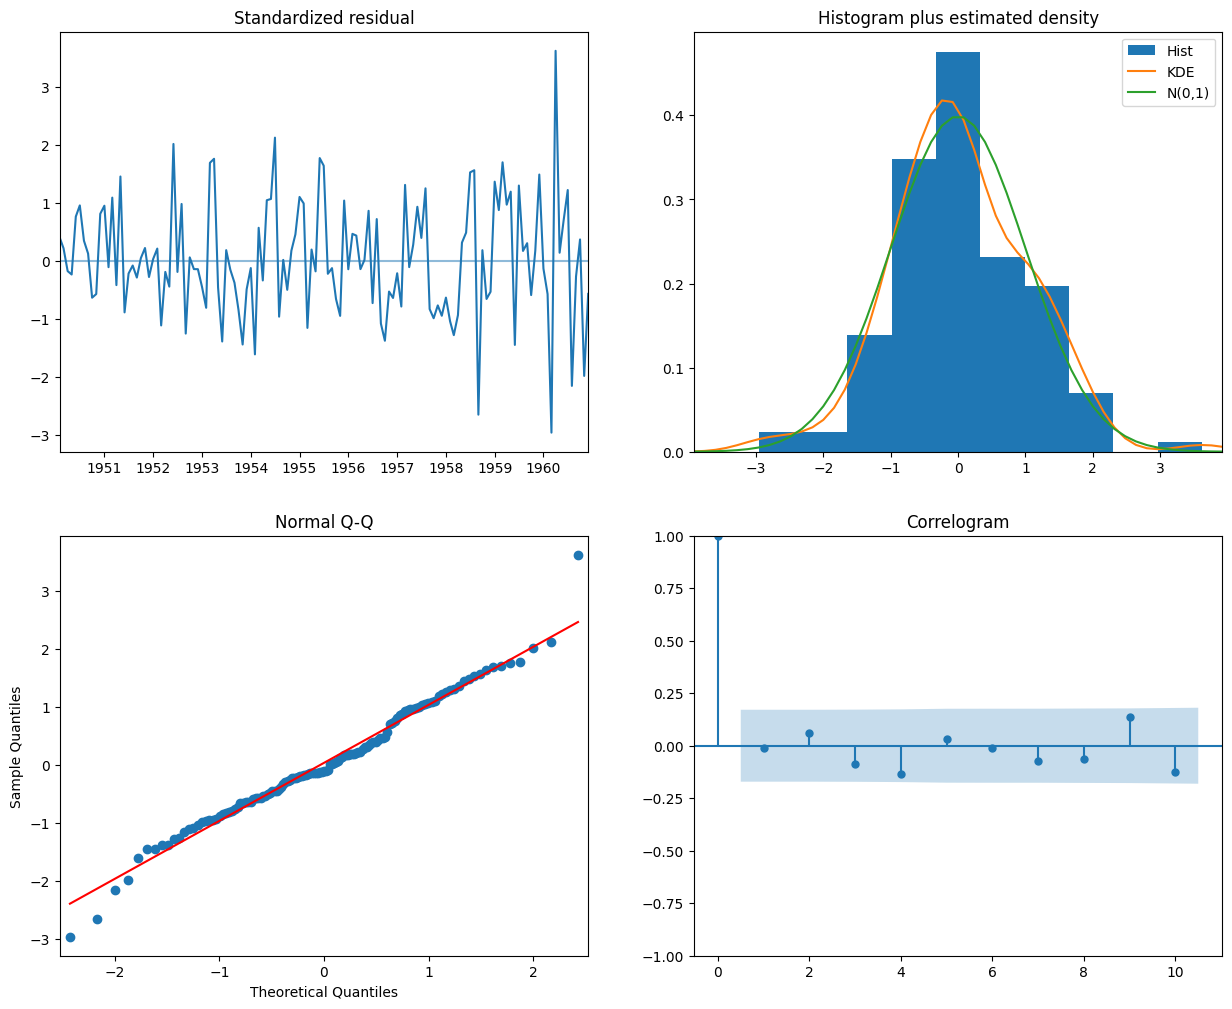

In [10]:
SARIMA_model.plot_diagnostics(figsize=(15,12))
plt.show()

We can then use the model to forecast airline passenger counts over the next 24 months as we did before.

As we can see from the plot below, this seems to be much more accurate than the standard ARIMA model!

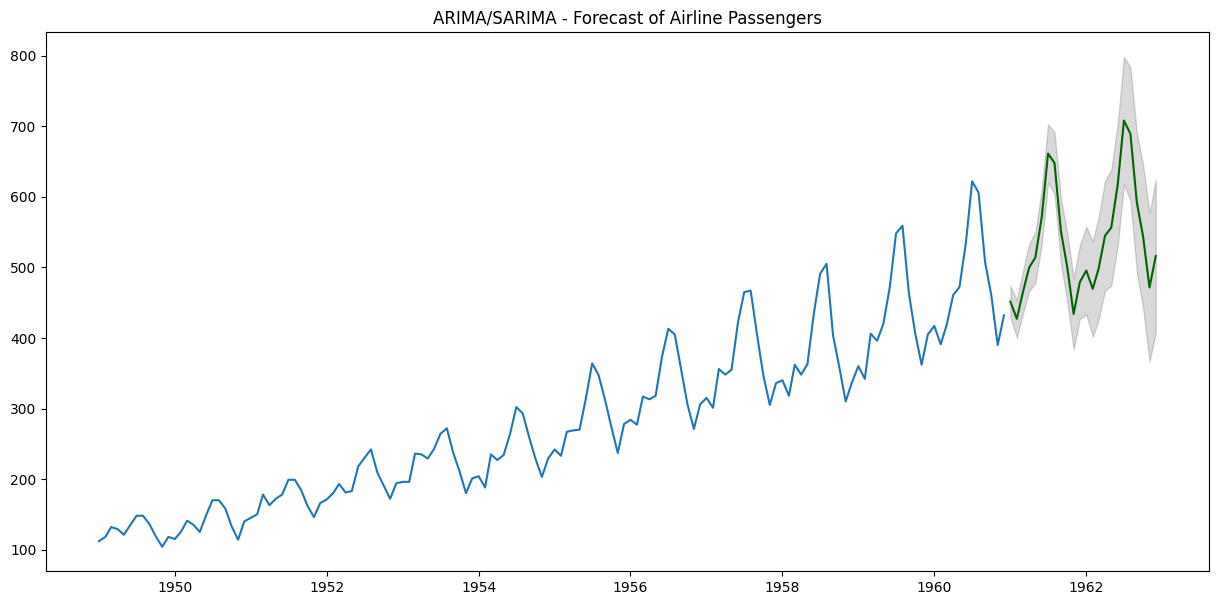

In [11]:
forecast(SARIMA_model)

## <center>SARIMAX Model Selection</center>

Now let's practice adding in an exogenous variable. In this example, I am simply going to add the month number as an exogenous variable, but this is not super useful as this is already conveyed through the seasonality.

Note that we are adding additional square brackets around the data being passed into the SARIMAX model.

In [12]:
#adding exogenous variable
df['month_index'] = df.index.month

# SARIMAX Model
SARIMAX_model = pm.auto_arima(df[['#Passengers']], exogenous=df[['month_index']],
                           start_p=1, start_q=1,
                           test='adf',
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=None, D=1,
                           trace=False,
                           error_action='ignore',
                           suppress_warnings=True,
                           stepwise=True)

SARIMAX_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  144
Model:             SARIMAX(0, 1, 1)x(2, 1, [], 12)   Log Likelihood                -505.589
Date:                             Sat, 26 Aug 2023   AIC                           1019.178
Time:                                     13:42:44   BIC                           1030.679
Sample:                                 01-01-1949   HQIC                          1023.851
                                      - 12-01-1960                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3634      0.074     -4.945      0.000      -0.508      -0.219
ar.S.L12      -0.1239      0.090     -1.372      0.170      -0.301       0.053
ar.S.L24       0.1911      0.107      1.783      0.075      -0.019       0.401
sigma2       130.4480     15.527      8.402      0.000     100.016     160.880
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 4.59
Prob(Q):                              0.92   Prob(JB):                         0.10
Heteroskedasticity (H):               2.70   Skew:                             0.15
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.87
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

We can see that similar to the SARIMA model we are getting some pretty good-looking predictions and the width of the forecasted confidence interval has decreased. This means that the model is more certain of its predictions.

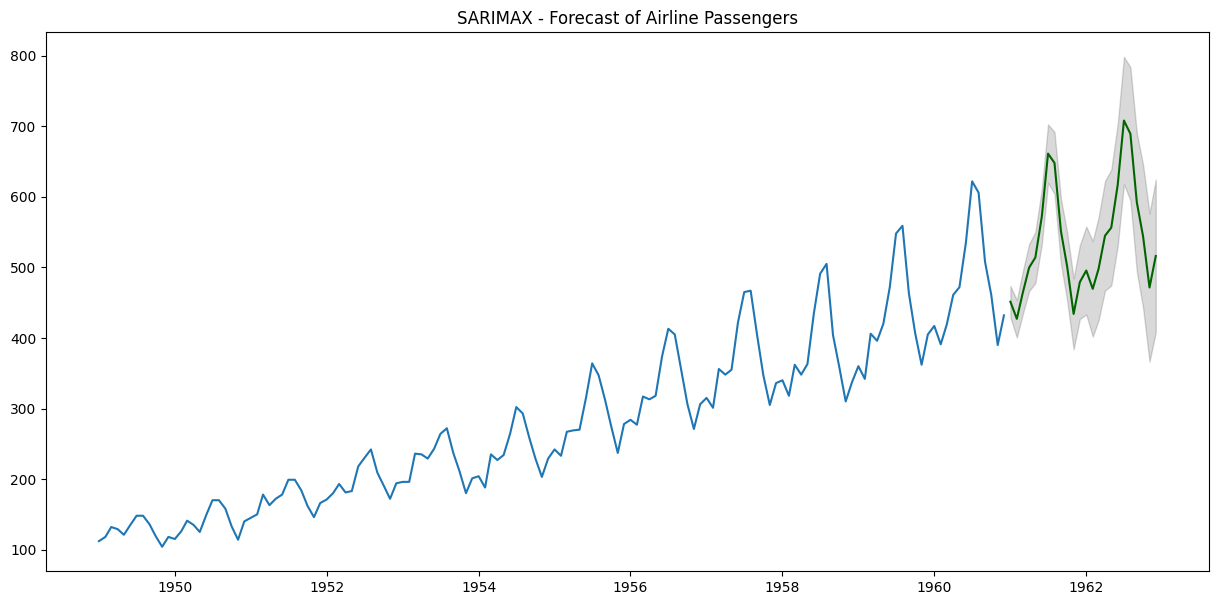

In [13]:
def sarimax_forecast(SARIMAX_model, periods=24):
    # Forecast
    n_periods = periods

    forecast_df = pd.DataFrame({"month_index":pd.date_range(df.index[-1], periods = n_periods, freq='MS').month},
                    index = pd.date_range(df.index[-1]+ pd.DateOffset(months=1), periods = n_periods, freq='MS'))

    fitted, confint = SARIMAX_model.predict(n_periods=n_periods,
                                            return_conf_int=True,
                                            exogenous=forecast_df[['month_index']])
    index_of_fc = pd.date_range(df.index[-1] + pd.DateOffset(months=1), periods = n_periods, freq='MS')

    # make series for plotting purpose
    fitted_series = pd.Series(fitted, index=index_of_fc)
    lower_series = pd.Series(confint[:, 0], index=index_of_fc)
    upper_series = pd.Series(confint[:, 1], index=index_of_fc)

    # Plot
    plt.figure(figsize=(15,7))
    plt.plot(df["#Passengers"], color='#1f76b4')
    plt.plot(fitted_series, color='darkgreen')
    plt.fill_between(lower_series.index,
                    lower_series,
                    upper_series,
                    color='k', alpha=.15)

    plt.title("SARIMAX - Forecast of Airline Passengers")
    plt.show()

sarimax_forecast(SARIMAX_model, periods=24)
